In [18]:
import geopandas as gpd
from pathlib import Path
import warnings
import hvplot.xarray
import pandas as pd
import xarray as xr
import numpy as np

import networkx as nx
import geonetworkx as gnx

warnings.filterwarnings("ignore")

In [21]:
river_network_fn = Path('../../data-cumberland/cumberland_rivreg_usace/rivreg.geojson')
river_network_pts_fn = Path('../../data-cumberland/cumberland_rivreg_usace/rivreg_pts.geojson')

river_network = gpd.read_file(river_network_fn)
river_network.to_xarray()

river_network_pts = gpd.read_file(river_network_pts_fn)
river_network_pts.to_xarray()

<xarray.Dataset>
Dimensions:    (index: 8)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6 7
Data variables:
    x          (index) object '-88.21874800000001' ... '-85.944131'
    y          (index) object '37.018747' '36.959995' ... '36.096527' '36.29222'
    name       (index) object 'Barkley_Dam' 'Laurel_Dam' ... 'Cordell_Hull_Dam'
    id         (index) int64 0 1 2 3 4 5 6 7
    elevation  (index) float64 106.0 301.0 196.0 195.0 131.0 148.0 201.0 158.0
    geometry   (index) object POINT (-88.218748 37.018747) ... POINT (-85.944...

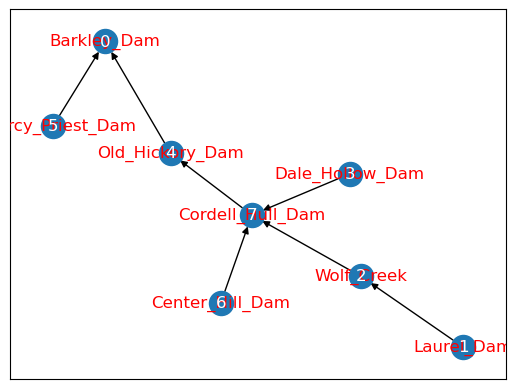

In [22]:
# quick and simple implementation without landlab

G = gnx.read_geofiles(river_network_pts_fn, river_network_fn, directed=True)
# nx.draw(G, nx.drawing.planar_layout(G))
pos = nx.drawing.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, labels={node:G.nodes[node]['name'] for node in G.nodes},font_color='red')
nx.draw_networkx_labels(G, pos,font_color='white');

# Compile data for river-regulation model

The following cells will workf if the `final_outputs` of RAT are being used. The `final_outputs` get created in the last step of RAT, which may or may not run based on the status of the previous steps. If it did run, use the following cells, otherwise, use the next section.

In [23]:
RUN_TYPE = 'E1'

start_date = "2015-01-01"
end_date = "2019-09-30"

rat_output_dir = Path("/water2/pdas47/2023_01_24-river-regulation/data-era5-2010_2021/tennessee/basins/cumberland/final_outputs")
# storage_change_dir = Path("/water2/pdas47/2023_01_24-river-regulation/data-cumberland/tennessee/basins/cumberland/final_outputs/dels") # satellite estimates of ∆S
unregulated_inflow_dir = rat_output_dir / "inflow"

regulation_data_fn = Path("/water2/pdas47/2023_01_24-river-regulation/regulation-experiments/regulation-data/insitu.2015-2019.nc")
regulation_data_fn.parent.mkdir(exist_ok=True)
regulation_data_output_fn = regulation_data_fn.with_suffix(f".regulated.{RUN_TYPE}.nc")

insitu_dir = Path("../../data/insitu/")  # observed ∆S, I, O

In [24]:
from bokeh.models.formatters import NumeralTickFormatter

# Prepare regulation input
# Code to make the regulation_data.nc file.
def read_unregulated_inflow(unregulated_inflow_fn):
    unregulated_inflow = pd.read_csv(unregulated_inflow_fn, parse_dates=['date']).rename({
        'date': 'time',
        'inflow (m3/d)': 'unregulated_inflow'
        }, axis='columns')
    # unregulated_inflow['unregulated_inflow'] = unregulated_inflow['unregulated_inflow'] * (24*60*60) # m3/s -> m3/day
    unregulated_inflow['node'] = node_id
    unregulated_inflow.set_index(['time', 'node'], inplace=True)
    unregulated_inflow = unregulated_inflow.to_xarray()
    
    return unregulated_inflow

def read_storage_change_rat(storage_change_fn):
    storage_change = pd.read_csv(storage_change_fn, parse_dates=['date']).rename({
        'date': 'time',
        'dS (m3)': 'storage_change'
    }, axis='columns')[['time', 'storage_change']]

    # convert storage_change to daily - https://stackoverflow.com/a/73724900
    storage_change = storage_change.set_index('time')
    storage_change = storage_change.resample('1D').apply(lambda x: np.nan if x.empty else x)
    groups = storage_change['storage_change'].notna()[::-1].cumsum()
    storage_change['storage_change'] = storage_change['storage_change'].fillna(0).groupby(groups).transform('mean')
    storage_change['node'] = node_id
    storage_change = storage_change.reset_index().set_index(['time', 'node'])
    storage_change = storage_change.to_xarray()

    return storage_change

def read_insitu(insitu_fn, node_id):
    dels_derived = False
    
    insitu = pd.read_csv(insitu_fn, parse_dates=['date']).rename({'date': 'time'}, axis=1)

    insitu['node'] = node_id
    
    to_merge = []
    # observed inflow
    obs_inflow = insitu[['time', 'node', 'inflow']].rename({'inflow': 'obs_inflow'}, axis=1)
    obs_inflow.set_index(['time', 'node'], inplace=True)
    obs_inflow = obs_inflow.to_xarray() * (24*60*60) # m3/s -> m3/day
    to_merge.append(obs_inflow)

    # observed outflow (if available)
    if 'outflow' in insitu.columns:
        obs_outflow = insitu[['time', 'node', 'outflow']].rename({'outflow': 'obs_outflow'}, axis=1)
        obs_outflow.set_index(['time', 'node'], inplace=True)
        obs_outflow = obs_outflow.to_xarray() * (24*60*60) # m3/s -> m3/day
        to_merge.append(obs_outflow)

    if not 'storage_change' in insitu.columns:
        obs_storage_change = insitu[['time', 'node', 'storage']].rename({'storage': 'obs_storage_change'}, axis=1)
        obs_storage_change.set_index(['time', 'node'], inplace=True)
        obs_storage_change['obs_storage_change'] = obs_storage_change['obs_storage_change'] * 1e6  # MCM to CM
        obs_storage_change['obs_storage_change'] = obs_storage_change['obs_storage_change'].diff()
    else:
        obs_storage_change = insitu[['time', 'node', 'storage_change']].rename({'storage_change': 'obs_storage_change'}, axis=1)
        obs_storage_change.set_index(['time', 'node'], inplace=True)
        obs_storage_change['obs_storage_change'] = obs_storage_change['obs_storage_change'] * 1e6 # MCM to CM

    obs_storage_change = obs_storage_change.to_xarray()
    to_merge.append(obs_storage_change)

    return xr.merge(to_merge)


datasets_to_join = []

for node_id in G:
    node = G.nodes[node_id]
    name = node['name']

    # natural inflow
    unregulated_inflow_fn = unregulated_inflow_dir / f"{name}.csv"
    if not unregulated_inflow_fn.exists():
        print(f"Missing {unregulated_inflow_fn}")
        continue
    unregulated_inflow = read_unregulated_inflow(unregulated_inflow_fn)
    datasets_to_join.append(unregulated_inflow)

    # insitu data
    insitu_fn = insitu_dir / f"{name}.csv"
    insitu = read_insitu(insitu_fn, node_id)
    datasets_to_join.append(insitu)


regulation_data = xr.merge(datasets_to_join).sel(time=slice(start_date, end_date))
regulation_data

<xarray.Dataset>
Dimensions:             (time: 1734, node: 8)
Coordinates:
  * time                (time) datetime64[ns] 2015-01-01 ... 2019-09-30
  * node                (node) int64 0 1 2 3 4 5 6 7
Data variables:
    unregulated_inflow  (time, node) float64 9.186e+07 1.137e+06 ... 1.111e+06
    obs_inflow          (time, node) float64 1.409e+08 1.201e+06 ... 7.098e+06
    obs_outflow         (time, node) float64 1.409e+08 1.713e+06 ... 1.125e+07
    obs_storage_change  (time, node) float64 0.0 -8.02e+05 ... -3e+03 -4.159e+06

In [26]:
regulation_data.to_netcdf(regulation_data_output_fn)

# create regualtion dataset using satellite derived storage changes

In [10]:
storage_change_dir = Path("/water2/pdas47/2023_01_24-river-regulation/data-cumberland/dels/")

datasets_to_join = []

for node_id in G:
    node = G.nodes[node_id]
    name = node['name']

    # natural inflow
    unregulated_inflow_fn = unregulated_inflow_dir / f"{name}.csv"
    if not unregulated_inflow_fn.exists():
        print(f"Missing {unregulated_inflow_fn}")
        continue
    unregulated_inflow = read_unregulated_inflow(unregulated_inflow_fn)
    datasets_to_join.append(unregulated_inflow)
    
    # storage change
    storage_change_fn = storage_change_dir / f"{name}.csv"
    if storage_change_fn.exists():
        storage_change = read_storage_change_rat(storage_change_fn)
        datasets_to_join.append(storage_change)

    # insitu data
    insitu_fn = insitu_dir / f"{name}.csv"
    insitu = read_insitu(insitu_fn, node_id)
    datasets_to_join.append(insitu)

regulation_data = xr.merge(datasets_to_join)
regulation_data

<xarray.Dataset>
Dimensions:             (time: 30330, node: 9)
Coordinates:
  * time                (time) datetime64[ns] 1938-10-01 ... 2021-10-14
  * node                (node) int64 0 1 2 3 4 5 6 7 8
Data variables:
    unregulated_inflow  (time, node) float64 nan nan nan nan ... nan nan nan nan
    storage_change      (time, node) float64 nan nan nan nan ... nan nan nan nan
    obs_inflow          (time, node) float64 nan nan nan nan ... nan nan nan nan
    obs_outflow         (time, node) float64 nan nan nan nan ... nan nan nan nan
    obs_storage_change  (time, node) float64 nan nan nan nan ... nan nan nan nan

In [11]:
rat_dels_hv = regulation_data.sel(time=slice('2018-01-01', '2019-03-01'), node=6).hvplot('time', 'storage_change').opts(yformatter=NumeralTickFormatter(format='0.0 a'))
obs_dels_hv = regulation_data.sel(time=slice('2018-01-01', '2019-03-01'), node=6).hvplot('time', 'obs_storage_change').opts(yformatter=NumeralTickFormatter(format='0.0 a'))
# obs_inflow_hv = regulation_data.sel(time=slice('2018-01-01', '2019-03-01'), node=6).hvplot('time', 'obs_inflow').opts(yformatter=NumeralTickFormatter(format='0.0 a'))
# obs_outflow_hv = regulation_data.sel(time=slice('2018-01-01', '2019-03-01'), node=6).hvplot('time', 'obs_outflow').opts(yformatter=NumeralTickFormatter(format='0.0 a'))


# rat_dels_hv * obs_dels_hv * obs_inflow_hv * obs_outflow_hv
rat_dels_hv * obs_dels_hv # * obs_inflow_hv * obs_outflow_hv

:Overlay
   .Curve.I  :Curve   [time]   (storage_change)
   .Curve.II :Curve   [time]   (obs_storage_change)

In [13]:
regulation_data_fn = Path('../../data-era5-2010_2021/regulation/regulation_data.RAT.nc')

regulation_data.to_netcdf(regulation_data_fn)